##### Notatki
Tutorial tutaj: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

Dane Flickr 8k:
https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

Polskie podpisy: http://zil.ipipan.waw.pl/Scwad/AIDe?action=AttachFile&do=get&target=AIDe_ANNOTATED_DESCRIPTIONS.zip

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from statistics import mean
from unidecode import unidecode
import nltk
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

Using TensorFlow backend.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ostry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
learn_modes = ['pl', 'no_pl', 'lemma', 'lemma_no_pl']

In [3]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

doc = {}
# load descriptions
for learn_mode in learn_modes:
    doc[learn_mode] = load_doc(f'../AIDe_ANNOTATED_DESCRIPTIONS/token_{learn_mode}.txt')

In [4]:
# create dictionary 'mapping' that contains all names of images without 
# .jpg extention and their corresponding descriptons
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

descriptions = {}

# parse descriptions
for learn_mode in learn_modes:
    descriptions[learn_mode] = load_descriptions(doc[learn_mode])
    print(learn_mode, 'loaded: %d ' % len(descriptions[learn_mode]))

pl loaded: 1000 
no_pl loaded: 1000 
lemma loaded: 1000 
lemma_no_pl loaded: 1000 


In [6]:
# prepare translation table by removing numbers, non-letter characters and by lowercasing the text
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# execute clean descriptions function
for learn_mode in learn_modes:
    clean_descriptions(descriptions[learn_mode])

In [7]:
# Function for creating vocabulary of all words present from loaded descriptions
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

vocabulary = {}

# count unique words in vocabulary
for learn_mode in learn_modes:
    vocabulary[learn_mode] = to_vocabulary(descriptions[learn_mode])
    print(learn_mode, 'vocabulary Size: %d' % len(vocabulary[learn_mode]))

pl vocabulary Size: 3273
no_pl vocabulary Size: 3273
lemma vocabulary Size: 3273
lemma_no_pl vocabulary Size: 3273


In [8]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '../AIDe_ANNOTATED_DESCRIPTIONS/trainImages.txt'
train = load_set(filename)
print('Train dataset: %d' % len(train))

filename = '../AIDe_ANNOTATED_DESCRIPTIONS/testImages.txt'
test = load_set(filename)
print('Train dataset: %d' % len(test))

Train dataset: 782
Train dataset: 218


In [9]:
# Below path contains all the images
images = '../Flickr8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [10]:
# Below file conatains the names of images to be used in train data
train_images_file = '../AIDe_ANNOTATED_DESCRIPTIONS/trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [11]:
# Below file conatains the names of images to be used in test data
test_images_file = '../AIDe_ANNOTATED_DESCRIPTIONS/testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [12]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset, isForTraining):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			if isForTraining:
				desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			else:
				desc = ' '.join(image_desc)
			# store
			descriptions[image_id].append(desc)
	return descriptions

train_descriptions = {}
test_descriptions = {}
no_tokens_train_descriptions = {}

# descriptions
for learn_mode in learn_modes:
    train_descriptions[learn_mode] = load_clean_descriptions(f'descriptions_{learn_mode}.txt', train, True)
    print(f'Descriptions: train {learn_mode} = %d' % len(train_descriptions[learn_mode]))
    test_descriptions[learn_mode] = load_clean_descriptions(f'descriptions_{learn_mode}.txt', test, False)
    print(f'Descriptions: test {learn_mode} = %d' % len(test_descriptions[learn_mode]))
    no_tokens_train_descriptions[learn_mode] = load_clean_descriptions(f'descriptions_{learn_mode}.txt', train, False)
    print(f'Descriptions: train no tokens {learn_mode} = %d' % len(no_tokens_train_descriptions[learn_mode]))

Descriptions: train pl = 782
Descriptions: test pl = 218
Descriptions: train no tokens pl = 782
Descriptions: train no_pl = 782
Descriptions: test no_pl = 218
Descriptions: train no tokens no_pl = 782
Descriptions: train lemma = 782
Descriptions: test lemma = 218
Descriptions: train no tokens lemma = 782
Descriptions: train lemma_no_pl = 782
Descriptions: test lemma_no_pl = 218
Descriptions: train no tokens lemma_no_pl = 782


In [13]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [14]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [15]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [16]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [17]:
train_features = {}

for learn_mode in learn_modes:
    train_features[learn_mode] = load(open(f'..//Pickle/encoded_train_images_{learn_mode}.pkl', 'rb'))
    print(f'Photos: train {learn_mode} = %d' % len(train_features[learn_mode]))

Photos: train pl = 782
Photos: train no_pl = 782
Photos: train lemma = 782
Photos: train lemma_no_pl = 782


In [18]:
all_train_captions = {}

# Create a list (all_train_captions) that cotains all of the training captions
for learn_mode in learn_modes:
    all_train_captions[learn_mode] = []
    for key, val in train_descriptions[learn_mode].items():
        for cap in val:
            all_train_captions[learn_mode].append(cap)

In [19]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
vocab = {}

for learn_mode in learn_modes:
    word_counts[learn_mode] = {}
    nsents = 0
    for sent in all_train_captions[learn_mode]:
        nsents += 1
        for w in sent.split(' '):
            word_counts[learn_mode][w] = word_counts[learn_mode].get(w, 0) + 1
    vocab[learn_mode] = [w for w in word_counts[learn_mode] if word_counts[learn_mode][w] >= word_count_threshold]
    print(f'preprocessed words {learn_mode} %d -> %d' % (len(word_counts[learn_mode]), len(vocab[learn_mode])))

preprocessed words pl 2816 -> 229
preprocessed words no_pl 2788 -> 231
preprocessed words lemma 1581 -> 231
preprocessed words lemma_no_pl 1579 -> 231


In [20]:
ixtoword = {}
wordtoix = {}

#create utility lists that math index to word and word to index
for learn_mode in learn_modes:
    ixtoword[learn_mode] = {}
    wordtoix[learn_mode] = {}
    ix = 1
    for w in vocab[learn_mode]:
        wordtoix[learn_mode][w] = ix
        ixtoword[learn_mode][ix] = w
        ix += 1  

In [21]:
vocab_size = {}

for learn_mode in learn_modes:
    vocab_size[learn_mode] = len(ixtoword[learn_mode]) + 1 #  + 1 is for appendeding 0's, needed for word embedding

In [22]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def get_max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = {}

# determine the maximum sequence length
for learn_mode in learn_modes:
    max_length[learn_mode] = get_max_length(train_descriptions[learn_mode])
    print(f'Description Length {learn_mode}: %d' % max_length[learn_mode])

Description Length pl: 26
Description Length no_pl: 26
Description Length lemma: 26
Description Length lemma_no_pl: 26


Embedings pobrane stąd: https://github.com/sdadas/polish-nlp-resources/releases/download/v1.0/glove.zip

In [23]:
# Load Glove vectors - each of length = 200
glove_dir = '../glove'
embeddings_index = {}
for learn_mode in learn_modes:
    embeddings_index[learn_mode] = {}
f = open(os.path.join(glove_dir, 'glove_100_3_polish.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    coefs = np.asarray(values[1:], dtype='float32')
    for learn_mode in learn_modes:
        word = values[0] if learn_mode != 'no_pl' else unidecode(values[0])
        embeddings_index[learn_mode][word] = coefs
        
f.close()
print('Found %s word vectors.' % len(embeddings_index['pl']))

Found 1926321 word vectors.


In [24]:
embedding_dim = 100
embedding_matrix = {}


# Get 200-dim dense vector for each of the 10000 words in out vocabulary
for learn_mode in learn_modes:
    embedding_matrix[learn_mode] = np.zeros((vocab_size[learn_mode], embedding_dim))

    for word, i in wordtoix[learn_mode].items():
        #if i < max_words:
        embedding_vector = embeddings_index[learn_mode].get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[learn_mode][i] = embedding_vector

In [25]:
embedding_matrix['pl'].shape

(230, 100)

In [26]:
models = {}
#Creation of the model

for learn_mode in learn_modes:
    # image feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # partial caption sequence model
    inputs2 = Input(shape=(max_length[learn_mode],))
    se1 = Embedding(vocab_size[learn_mode], embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder (feed forward) model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size[learn_mode], activation='softmax')(decoder2)
    # merge of the two input models
    models[learn_mode] = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [27]:
#inclusion of embedded glove vectors
for learn_mode in learn_modes:
    models[learn_mode].layers[2].set_weights([embedding_matrix[learn_mode]])
    models[learn_mode].layers[2].trainable = False

In [28]:
#model copmplation with adam optimizer
for learn_mode in learn_modes:
    models[learn_mode].compile(loss='categorical_crossentropy', optimizer='adam')

In [29]:
#load weights obtained through backpropagation
for learn_mode in learn_modes:
    models[learn_mode].load_weights(f'../model_weights/model_30_{learn_mode}.h5')

In [30]:
images = '../Flickr8k_Dataset/'

In [31]:
encoding_train = {}
encoding_test = {}

#load image features from pickle files
for learn_mode in learn_modes:
    with open(f'../Pickle/encoded_train_images_{learn_mode}.pkl', 'rb') as encoded_pickle:
        encoding_train[learn_mode] = load(encoded_pickle)
    with open(f'../Pickle/encoded_test_images_{learn_mode}.pkl', 'rb') as encoded_pickle:
        encoding_test[learn_mode] = load(encoded_pickle)

In [32]:
#Function for generating captions for image. It is greedy function because it predicts next best possible word 
#in sentence given image features and previous predicted word in the sentence. Alghorithm stops when it reaches
#max possible length of caption or the word endseq.

def greedy_search(photo, learn_mode):
    in_text = 'startseq'
    for i in range(max_length[learn_mode]):
        sequence = [wordtoix[learn_mode][w] for w in in_text.split() if w in wordtoix[learn_mode]]
        sequence = pad_sequences([sequence], maxlen=max_length[learn_mode])
        yhat = models[learn_mode].predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[learn_mode][yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
#sources:
#https://www.researchgate.net/publication/268689555_CIDEr_Consensus-based_Image_Description_Evaluation
#https://www.sciencedirect.com/topics/computer-science/cosine-similarity
#https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/

#function for calculating cider metric
def cider(given_captions, prediction):
    prediction_arr = []
    prediction_arr.append(prediction)
    vectorizer = TfidfVectorizer()
    trainedV = vectorizer.fit(given_captions)
    givenTfIdf = trainedV.transform(given_captions).toarray()
    predTfIdf = trainedV.transform(prediction_arr).toarray()
    partialCiders = 0
    help_arr = []
    
    for c in givenTfIdf:
        help_arr.append(c)
        partialCiders = partialCiders + cosine_similarity(predTfIdf,help_arr)
        help_arr = []
        
    return partialCiders/len(givenTfIdf)

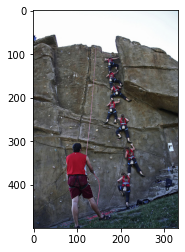

Test 0 : duzy pies obroza
Meteor score:  0.0
Cider score:  [[0.]]


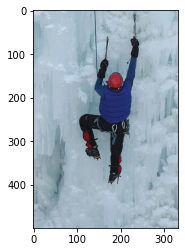

Test 1 : dziecko kasku zjezdza sniegu
Meteor score:  0.0
Cider score:  [[0.]]


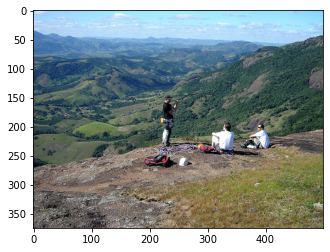

Test 2 : dziewczynki
Meteor score:  0.0
Cider score:  [[0.]]


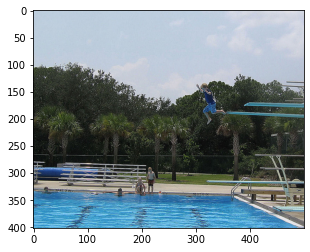

Test 3 : maly chlopiec kapeluszu kapeluszu plytkiej wodzie
Meteor score:  0.0
Cider score:  [[0.]]


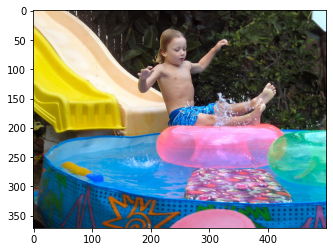

Test 4 : maly ptak dlugimi
Meteor score:  0.0
Cider score:  [[0.]]


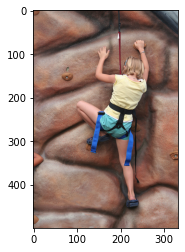

Test 5 : mlody chlopak bialej czapce siedzi
Meteor score:  0.0
Cider score:  [[0.]]


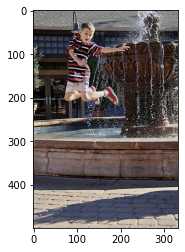

Test 6 : czarny pies pysku trawie brzegu wody
Meteor score:  0.0
Cider score:  [[0.]]


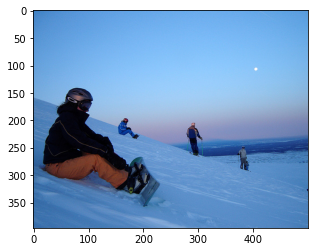

Test 7 : dziecko kasku zjezdza sniegu czerwonych sankach
Meteor score:  0.0
Cider score:  [[0.]]


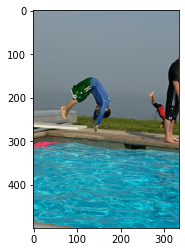

Test 8 : dziewczynka kostiumie kapielowym wodzie plazy
Meteor score:  0.0
Cider score:  [[0.]]


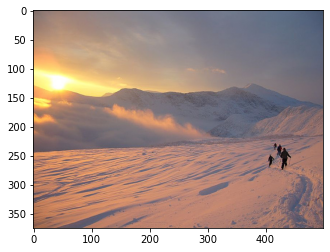

Test 9 : czlowiek wykonuje skok rowerze
Meteor score:  0.0
Cider score:  [[0.]]


In [35]:
#caption generation

pics = list(encoding_test['no_pl'].keys())

#for i in range(0,len(pics)):
for i in range(0,10):
    pic = pics[i]
    image = encoding_test['no_pl'][pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    caption = greedy_search(image, 'no_pl')
    
    
    print("Test",i,":",caption)
    print("Meteor score: ", meteor_score(descriptions['no_pl'][pic.split('.')[0]],caption))
    print("Cider score: ", cider(descriptions['no_pl'][pic.split('.')[0]],caption))

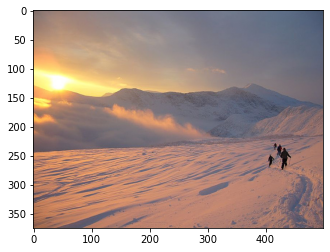

Test 9 : czlowiek wykonywac skok rower
['osoba przemierzac zasniezyc teren niedaleko gorski wzniesienie', 'cztery osoba isc gleboki snieg gory']


In [36]:
pics = list(encoding_test['lemma_no_pl'].keys())

pic = pics[i]
image = encoding_test['lemma_no_pl'][pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
caption = greedy_search(image, 'lemma_no_pl')


print("Test",i,":",caption)
print(test_descriptions['lemma_no_pl'][pic.split('.')[0]])


In [37]:
# Bag of words = bow

def get_bow(description):
    bow = description.split(' ')
    bow = set(bow)
    return bow

#calculate bow score
def bow_score(bow_train, bow_pred):
    overlap = bow_train & bow_pred
    universe = bow_train | bow_pred

    result1 = float(len(overlap)) / len(bow_train) * 100
    result2 = float(len(overlap)) / len(bow_pred) * 100
    result3 = float(len(overlap)) / len(universe) * 100
    return result1, len(overlap)

In [38]:
test_descriptions['lemma_no_pl'][pic[:-4]]

['osoba przemierzac zasniezyc teren niedaleko gorski wzniesienie',
 'cztery osoba isc gleboki snieg gory']

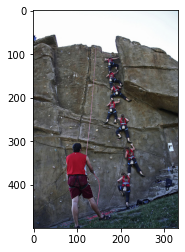

Greedy:czarnobialy pies obroza pilka teren
Bag of Words, words overlapping: 
percentage:            0.00%
literal:               0


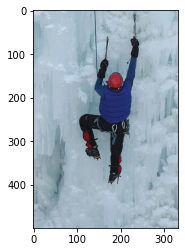

Greedy:dziecko zimowy stroj kask jechac snieg trzymac kij
Bag of Words, words overlapping: 
percentage:            0.00%
literal:               0


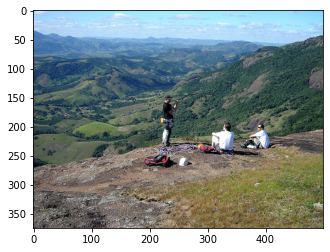

Greedy:mezczyzna okulary siedziec rower poblize
Bag of Words, words overlapping: 
percentage:           18.18%
literal:               2


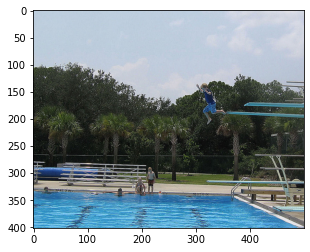

Greedy:maly chlopiec niebieski koszulka biec plaza
Bag of Words, words overlapping: 
percentage:           28.57%
literal:               2


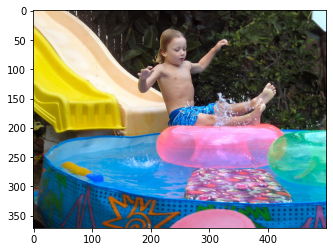

Greedy:dziewczynka chlopiec biec woda
Bag of Words, words overlapping: 
percentage:            6.67%
literal:               1


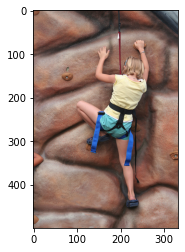

Greedy:maly chlopiec niebieski koszulka biec plaza
Bag of Words, words overlapping: 
percentage:            9.09%
literal:               1


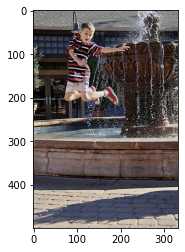

Greedy:czarny pies obroza szyja skakac drewniany woda
Bag of Words, words overlapping: 
percentage:            8.33%
literal:               1


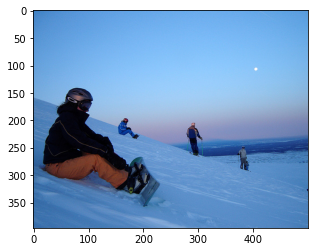

Greedy:dziecko zimowy stroj zjezdzac snieg czerwony sanki
Bag of Words, words overlapping: 
percentage:            6.25%
literal:               1


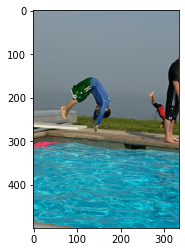

Greedy:maly chlopiec niebieski kapelusz biec plytki woda
Bag of Words, words overlapping: 
percentage:           15.38%
literal:               2


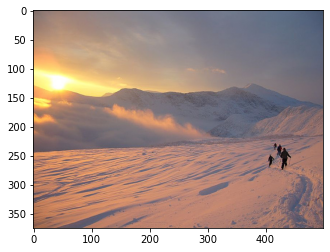

Greedy:czlowiek wykonywac skok rower
Bag of Words, words overlapping: 
percentage:            0.00%
literal:               0


In [39]:
for i in range(0,10):
    pic = pics[i]
    image = encoding_test['lemma_no_pl'][pic].reshape((1,2048))
    
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    train_description = ' '.join(test_descriptions['lemma_no_pl'][pic[:-4]])
    pred_description = greedy_search(image, 'lemma_no_pl')
    bow_train = get_bow(train_description)
    bow_pred = get_bow(pred_description)
    bow_score_percent, bow_score_literal = bow_score(bow_train, bow_pred)
    print("Greedy:{}".format(pred_description))
    print("Bag of Words, words overlapping: ")
    print("percentage:      {:10.2f}%".format(bow_score_percent))
    print("literal:               {}".format(bow_score_literal))

In [41]:
import warnings; warnings.simplefilter('ignore')
from IPython.display import clear_output

#verification of model quality by calculating average score with various metrics (BLEU, Meteor, CIDEr)

train_pics = list(encoding_train[learn_mode].keys())
test_pics = list(encoding_test[learn_mode].keys())

#preparation of metrics lists
bleu_train_scores = {}    
meteor_train_scores = {}
cider_train_scores = {}

bleu_test_scores = {}    
meteor_test_scores = {}
cider_test_scores = {}

for learn_mode in learn_modes:
    bleu_train_scores[learn_mode] = []
    meteor_train_scores[learn_mode] = []
    cider_train_scores[learn_mode] = []

    bleu_test_scores[learn_mode] = []
    meteor_test_scores[learn_mode] = []
    cider_test_scores[learn_mode] = []

#calculation of metrics for train images dataset
for i in range(0,len(train_pics)):
    for learn_mode in learn_modes:
        pic = train_pics[i]
        image = encoding_train[learn_mode][pic].reshape((1,2048))

        actual_desc_0 = no_tokens_train_descriptions[learn_mode][pic[:-4]][0]
        actual_desc_1 = no_tokens_train_descriptions[learn_mode][pic[:-4]][1]
        generated = greedy_search(image,learn_mode)
        bleu_train_scores[learn_mode].append(
            sentence_bleu(
                [actual_desc_0.split(), actual_desc_1.split()],
                generated.split())
        )
        meteor_train_scores[learn_mode].append(meteor_score(no_tokens_train_descriptions[learn_mode][pic.split('.')[0]],generated))
        cider_train_scores[learn_mode].append(cider(no_tokens_train_descriptions[learn_mode][pic.split('.')[0]],generated)[0][0])
    
    clear_output(wait=True)
    print('train',i, flush=True)

#calculation of metrics for test images dataset
for i in range(0,len(test_pics)):
    for learn_mode in learn_modes:
        pic = test_pics[i]
        image = encoding_test[learn_mode][pic].reshape((1,2048))

        actual_desc_0 = test_descriptions[learn_mode][pic[:-4]][0]
        actual_desc_1 = test_descriptions[learn_mode][pic[:-4]][1]
        generated = greedy_search(image,learn_mode)
        bleu_test_scores[learn_mode].append(
            sentence_bleu(
                [actual_desc_0.split(), actual_desc_1.split()],
                generated.split())
        )
        meteor_test_scores[learn_mode].append(meteor_score(test_descriptions[learn_mode][pic.split('.')[0]],generated))
        cider_test_scores[learn_mode].append(cider(test_descriptions[learn_mode][pic.split('.')[0]],generated)[0][0])
    
    clear_output(wait=True)
    print('test',i, flush=True)

learn_modes_label = {
    'pl': 'oryginał',
    'no_pl': 'bez polskich znaków',
    'lemma': 'lematyzacja',
    'lemma_no_pl': 'lematyzacja bez polskich znaków'
}

result_data = {}

#calculate mean score based on socres list for each metric
for learn_mode in learn_modes:
    result_data[learn_modes_label[learn_mode]] = [
        mean(bleu_train_scores[learn_mode]),
        mean(bleu_test_scores[learn_mode]),
        mean(meteor_train_scores[learn_mode]),
        mean(meteor_test_scores[learn_mode]),
        mean(cider_train_scores[learn_mode]),
        mean(cider_test_scores[learn_mode])
    ]

result = pd.DataFrame.from_dict(
    result_data,
    orient='index',
    columns=['Bleu TREN', 'Bleu TEST', 'Meteor TREN', 'Meteor TEST', 'CIDEr TREN', 'CIDEr TEST']
)

result

test 217


Bleu TREN      Bleu TEST  Meteor TREN  \
oryginał                          0.003391  1.571193e-156     0.105498   
bez polskich znaków               0.006514  1.073403e-156     0.111192   
lematyzacja                       0.015116   2.409763e-80     0.149628   
lematyzacja bez polskich znaków   0.015624   4.767859e-80     0.128115   

                                 Meteor TEST  CIDEr TREN  CIDEr TEST  
oryginał                            0.035312    0.209776    0.102207  
bez polskich znaków                 0.027737    0.202342    0.075635  
lematyzacja                         0.054423    0.280611    0.156685  
lematyzacja bez polskich znaków     0.049582    0.241331    0.121460

In [ ]:
#Wniosek 1: polskie znaki niosą dodatkową informację która pozwala na stworzenie bardziej dostosowanych napisów
#Wniosek 2: Każda z metryk osiągnęła wyniki na stosunkowo niskim poziomie - główną przyczyną jest najprawdopodobniej
#mała liczba danych treningowych - jedynie po 2 wzorcowe zdania na obraz
#Wniosek 3: Powodem dla którego miara Meteor wyraźnie lepiej radzi sobie od miary Bleu jest to że pozwala ona na wykrywanie synonimów
#Wniosek 4: Powodem dla którego miara CIDEr radzi sobie najlepiej jest normalizacja danych oraz
#podejście które przyznaje wysoki wynik w sytuacji gdy rzadko występujące, specyficzne słowo dla danej sytuacji
#z obrazka zostanie zaproponowane w napisie.
